# Informe Final Carrera
Profundiza y ajusta la resolución de tus proyectos: agrega al menos una fuente de datos o prueba un modelo que hasta el momento no hayas aplicado. Elabora un informe ?nal que describa el proceso de toma de decisiones. Sustenta la razón por la cual usaste las librerías y aplicaste los métodos al dataset. Todos tus hallazgos deberán ser comunicados en función de la problemática y las preguntas que buscabas responder.

## Banksim dataset

Detectaremos las transacciones fraudulentas del conjunto de datos de Banksim. Este **conjunto de datos generado sintéticamente** consiste en pagos de varios clientes hechos en diferentes períodos de tiempo y con diferentes cantidades. Para más información sobre el conjunto de datos, puede consultar la página de [Kaggle](https://www.kaggle.com/ntnu-testimon/banksim1) para este conjunto de datos que también tiene el enlace al documento original.  

Los pasos a seguir en el presente estudio, serán los siguientes:

1. Exploratory Data Analysis (EDA)
2. Data Preprocessing
3. Oversampling with SMOTE
4. K-Neighbours Classifier
5. Random Forest Classifier
6. XGBoost Classifier
7. Conclusión

### 1. Análisis Exploratorio de Datos

1. __Se importan las librerías__ necesarias para trabajar en la consigna.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

2. __Se realiza la carga el dataset__ usando las funcionalidades de Pandas.

In [2]:
banksim = pd.read_csv('bs140513_032310.csv')

In [3]:
banksim.shape

(594643, 10)

* *El Dataset, cuenta con **594.643 Filas**, y **10 Columnas**.*

In [4]:
banksim.head()

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0


3. Se realiza una __descripción__ de las características:  

* *Step:* Representa el día desde el comienzo de la simulación. Tiene 180 pasos, por lo que la simulación dura virtualmente 6 meses.  
* *Customer:* Representa la identificación del cliente.  
* *zipCodeOrigin:* El código postal de origen/fuente.  
* *Merchant:* La identificación del comerciante.  
* *zipMerchant:* El código postal del comerciante.  
* *Edad:* Edad categorizada, las cuales se detallan a continuación:  
    * 0: <= 18,  
    * 1: 19-25,  
    * 2: 26-35,  
    * 3: 36-45,  
    * 4: 46-55,  
    * 5: 56-65,  
    * 6: > 65  
    * U: Desconocido  
* *Gender:* Género para el cliente.  
    * E : Enterprise,  
    * F: Mujer,  
    * M: Hombre,  
    * U: Desconocido  
* *Category:* Categoría de la compra. A posteriori se verán con más detalle.  
* *Amount:* Cantidad de la compra.  
* *Fraud:* Variable objetivo que muestra si la transacción es fraudulenta(1) o no (0).

4. __Info por Columna:__ Se imprimen los nombres de cada columna, a qué tipo de dato corresponden y sus valores faltantes.

In [5]:
banksim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   step         594643 non-null  int64  
 1   customer     594643 non-null  object 
 2   age          594643 non-null  object 
 3   gender       594643 non-null  object 
 4   zipcodeOri   594643 non-null  object 
 5   merchant     594643 non-null  object 
 6   zipMerchant  594643 non-null  object 
 7   category     594643 non-null  object 
 8   amount       594643 non-null  float64
 9   fraud        594643 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 45.4+ MB


* *Ninguna columna tiene valores faltantes, lo cual es lógico por tratarse de un dataset sintético.*
* *Por ello, es que no será necesario realizar imputación de valores.*

5. Análisis del feature **Fraude**.

* *Los datos de los fraudes estarán desequilibrados como se ve en el gráfico de abajo y en el recuento de instancias.*  
* *Para equilibrar el conjunto de datos se pueden realizar técnicas de sobremuestreo o submuestreo.*  
* *El sobremuestreo es aumentar el número de la clase minoritaria generando instancias de la clase minoritaria.*  
* *El submuestreo consiste en reducir el número de instancias de la clase mayoritaria mediante la selección de puntos aleatorios de la misma hasta que sea igual a la clase minoritaria.*  
* *Ambas operaciones tienen algunos riesgos: El sobremuestreo creará copias o puntos de datos similares que a veces no serían útiles para el caso de la detección de fraudes porque las transacciones fraudulentas pueden variar. El submuestreo significa que perdimos puntos de datos y, por lo tanto, información.*  
* *En el presente análisis, realizaremos una técnica de sobremuestreo llamada SMOTE (técnica de sobremuestreo de minorías sintéticas).*  
* *SMOTE creará nuevos puntos de datos de la clase minoritaria utilizando las instancias vecinas, de modo que las muestras generadas no son copias exactas, sino que son similares a las instancias que tenemos.*

In [6]:
pd.unique(banksim['fraud'])

array([0, 1], dtype=int64)

Text(0.5, 1.0, 'Número de Customers')

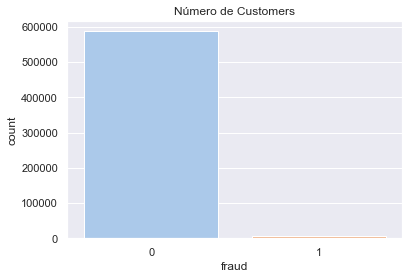

In [7]:
sns.countplot(data = banksim, x = 'fraud', order = banksim['fraud'].value_counts().index, palette='pastel')
plt.title('Número de Customers')

In [8]:
print(banksim['fraud'].value_counts().sum())

594643


In [9]:
print(banksim['fraud'].value_counts())

0    587443
1      7200
Name: fraud, dtype: int64


* *Vemos que las instancias con fraude representan un 98,8% del total, pudiendo corroborarse el desbalanceo del dataset.*

6. Análisis del feature **Fraude por Categoría**.

In [10]:
pd.unique(banksim['category'])

array(["'es_transportation'", "'es_health'", "'es_otherservices'",
       "'es_food'", "'es_hotelservices'", "'es_barsandrestaurants'",
       "'es_tech'", "'es_sportsandtoys'", "'es_wellnessandbeauty'",
       "'es_hyper'", "'es_fashion'", "'es_home'", "'es_contents'",
       "'es_travel'", "'es_leisure'"], dtype=object)

In [11]:
print(banksim['category'].value_counts())

'es_transportation'        505119
'es_food'                   26254
'es_health'                 16133
'es_wellnessandbeauty'      15086
'es_fashion'                 6454
'es_barsandrestaurants'      6373
'es_hyper'                   6098
'es_sportsandtoys'           4002
'es_tech'                    2370
'es_home'                    1986
'es_hotelservices'           1744
'es_otherservices'            912
'es_contents'                 885
'es_travel'                   728
'es_leisure'                  499
Name: category, dtype: int64


* *Además, podemos ver la cantidad media y el porcentaje de fraude por categoría a continuación.*
* *Parece que el **ocio y los viajes son las categorías más seleccionadas por los defraudadores**.*
* *Los defraudadores eligieron las categorías en las que la gente gasta más en promedio. Confirmemos esta hipótesis comprobando la cantidad de fraude y de no fraude que se ha tramitado.*

In [12]:
print("Cantidad media y porcentaje por categoriaa",banksim.groupby('category')['amount','fraud'].mean())

Cantidad media y porcentaje por categoriaa                               amount     fraud
category                                      
'es_barsandrestaurants'    43.461014  0.018829
'es_contents'              44.547571  0.000000
'es_fashion'               65.666642  0.017973
'es_food'                  37.070405  0.000000
'es_health'               135.621367  0.105126
'es_home'                 165.670846  0.152064
'es_hotelservices'        205.614249  0.314220
'es_hyper'                 45.970421  0.045917
'es_leisure'              288.911303  0.949900
'es_otherservices'        135.881524  0.250000
'es_sportsandtoys'        215.715280  0.495252
'es_tech'                 120.947937  0.066667
'es_transportation'        26.958187  0.000000
'es_travel'              2250.409190  0.793956
'es_wellnessandbeauty'     65.511221  0.047594


<ipython-input-12-e747060d8e56>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  print("Cantidad media y porcentaje por categoriaa",banksim.groupby('category')['amount','fraud'].mean())


7. Análisis de los features **Fraude por Monto o Gasto**.

In [13]:
pd.unique(banksim['amount'])

array([  4.55,  39.68,  26.89, ..., 249.18, 224.81, 190.31])

In [14]:
print(banksim['amount'].value_counts())

14.93     146
26.67     146
17.57     145
17.26     143
16.12     143
         ... 
751.43      1
274.43      1
517.95      1
105.02      1
429.60      1
Name: amount, Length: 23767, dtype: int64


* *Como vemos en el cuadro siguiente, podemos decir que en una transacción fraudulenta, será mucho mayor el monto o gasto (`amount`) -unas cuatro veces o más-, que el monto o gasto promedio para dicha categoría.*

In [15]:
# Create two dataframes with fraud and non-fraud data 
df_fraud = banksim.loc[banksim.fraud == 1] 
df_non_fraud = banksim.loc[banksim.fraud == 0]

In [16]:
pd.concat([df_fraud.groupby('category')['amount'].mean(),df_non_fraud.groupby('category')['amount'].mean(),\
           banksim.groupby('category')['fraud'].mean()*100],keys=["Fraudulent","Non-Fraudulent","Percent(%)"],axis=1,\
          sort=False).sort_values(by=['Non-Fraudulent'])

,Fraudulent,Non-Fraudulent,Percent(%)
'es_transportation',NaN,26.958187,0.000000
'es_food',NaN,37.070405,0.000000
'es_hyper',169.255429,40.037145,4.591669
'es_barsandrestaurants',164.092667,41.145997,1.882944
'es_contents',NaN,44.547571,0.000000
'es_wellnessandbeauty',229.422535,57.320219,4.759380
'es_fashion',247.008190,62.347674,1.797335
'es_leisure',300.286878,73.230400,94.989980
'es_otherservices',316.469605,75.685497,25.000000
'es_sportsandtoys',345.366811,88.502738,49.525237


* *Las categorías de gasto promedio son similares; entre 0-500 descartando los valores atípicos, excepto la categoría de viajes, que es muy alta.*

No handles with labels found to put in legend.


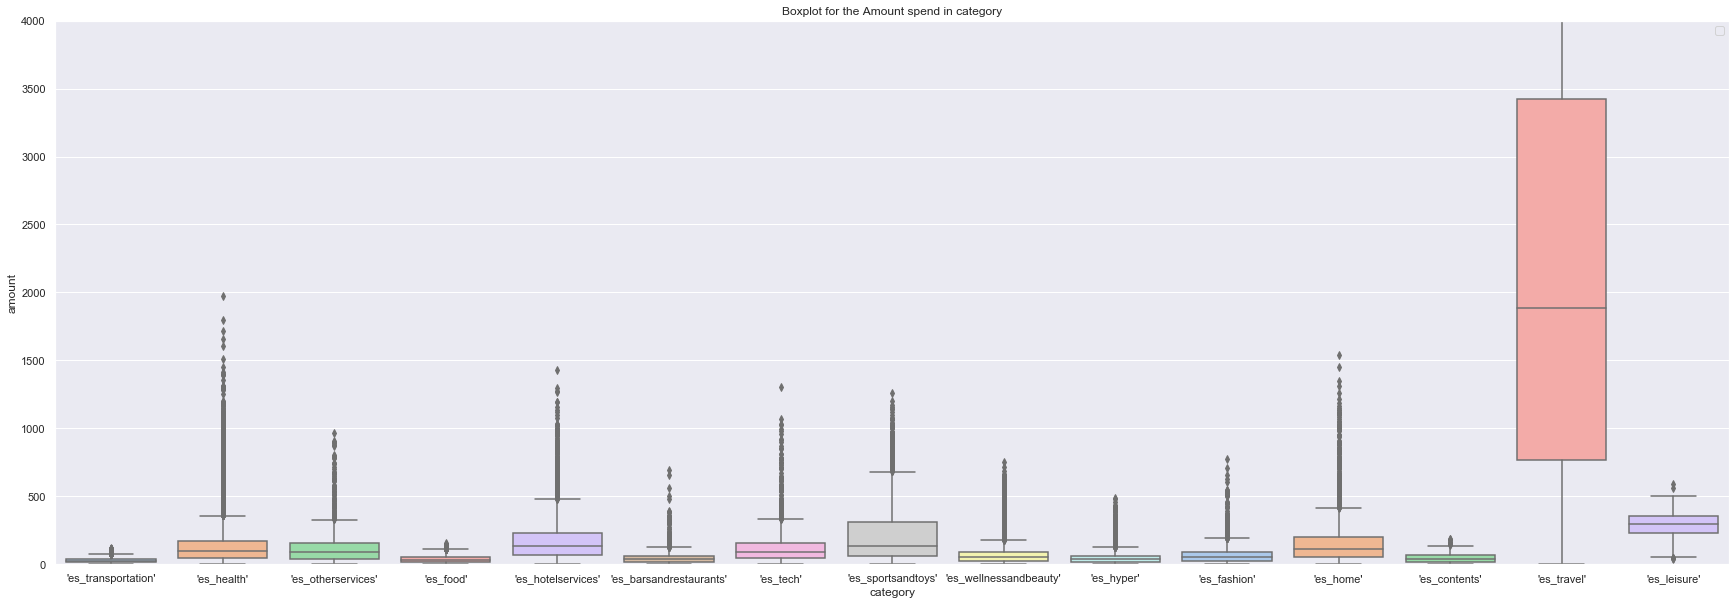

In [17]:
# Plot histograms of the amounts in fraud and non-fraud data 
plt.figure(figsize=(30,10))
sns.boxplot(x=banksim.category,y=banksim.amount,palette='pastel')
plt.title("Boxplot for the Amount spend in category")
plt.ylim(0,4000)
plt.legend()
plt.show()

* *Una vez más podemos ver en el histograma de abajo que las transacciones fradulentas son menos en cantidad pero más en monto.*

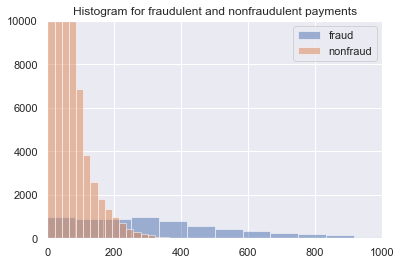

In [18]:
plt.hist(df_fraud.amount, alpha=0.5, label='fraud',bins=100)
plt.hist(df_non_fraud.amount, alpha=0.5, label='nonfraud',bins=100)
plt.title("Histogram for fraudulent and nonfraudulent payments")
plt.ylim(0,10000)
plt.xlim(0,1000)
plt.legend()
plt.show()

* *Con montos mayores a 400, ya poderíamos decir que hay fraude.*

8. Análisis de los features **Fraude por Edad**.

In [19]:
pd.unique(banksim['age'])

array(["'4'", "'2'", "'3'", "'5'", "'1'", "'6'", "'U'", "'0'"],
      dtype=object)

In [20]:
print(banksim['age'].value_counts())

'2'    187310
'3'    147131
'4'    109025
'5'     62642
'1'     58131
'6'     26774
'0'      2452
'U'      1178
Name: age, dtype: int64


* *Parece que **el fraude ocurre más en edades iguales y menores de 18 años (0º categoría)**. ¿Puede ser debido a que los estafadores piensan que habría menos consecuencias si muestran su edad más joven, o tal vez realmente son jóvenes.*

In [21]:
print((banksim.groupby('age')['fraud'].mean()*100).reset_index().rename(columns={'age':'Age','fraud' : 'Fraud Percent'}).sort_values(by='Fraud Percent'))

   Age  Fraud Percent
7  'U'       0.594228
6  '6'       0.974826
5  '5'       1.095112
1  '1'       1.185254
3  '3'       1.192815
2  '2'       1.251401
4  '4'       1.293281
0  '0'       1.957586


9. Análisis del feature **Customer**.

In [22]:
pd.unique(banksim['customer'])

array(["'C1093826151'", "'C352968107'", "'C2054744914'", ...,
       "'C1014783484'", "'C849065220'", "'C1809646275'"], dtype=object)

In [23]:
print(banksim['customer'].value_counts())

'C1978250683'    265
'C1275518867'    252
'C806399525'     237
'C515668508'     205
'C1338396147'    195
                ... 
'C1156745710'      6
'C1345586046'      6
'C1404665203'      5
'C1809646275'      5
'C1743702978'      5
Name: customer, Length: 4112, dtype: int64


In [24]:
#sns.countplot(data = banksim, y = 'customer', order = banksim['customer'].value_counts().index, palette='pastel')
#plt.title('Número de Customers')

10. Análisis de los features **Zip Code**.

In [25]:
print(banksim['zipcodeOri'].value_counts())

'28007'    594643
Name: zipcodeOri, dtype: int64


In [26]:
print(banksim['zipMerchant'].value_counts())

'28007'    594643
Name: zipMerchant, dtype: int64


* *Como se observa, hay un sólo tipo de Zip Code, tanto de Origen como de Comerciante, por lo que los descartaremos.*

In [27]:
banksim_reduced = banksim.drop(['zipcodeOri','zipMerchant'],axis=1)

In [28]:
banksim_reduced.columns

Index(['step', 'customer', 'age', 'gender', 'merchant', 'category', 'amount',
       'fraud'],
      dtype='object')

* *Vemos que se eliminaron ambos Zip Codes.*

In [ ]:
data_reduced.loc[:,['customer','merchant','category']].astype('category') data_dum = pd.get_dummies(data_reduced.loc[:,['customer','merchant','category','gender']],drop_first=True) # dummies print(data_dum.info())

5. __Encoders:__ Se aplicará Label Econding y One Hot Encoding sobre aquellos features con los que no podemos trabajar por ser categóricos.

In [8]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
banksim['age'] = le.fit_transform(banksim['age'])
print(banksim['age'])

0         4
1         2
2         4
3         3
4         5
         ..
594638    3
594639    4
594640    2
594641    5
594642    4
Name: age, Length: 594643, dtype: int32


6. __Distribución de los Datos:__ se realiza una visualización de los mismos.

In [9]:
banksim[['step','age','amount']].describe().round()

,step,age,amount
count,594643.0,594643.0,594643.0
mean,95.0,3.0,38.0
std,51.0,1.0,111.0
min,0.0,0.0,0.0
25%,52.0,2.0,14.0
50%,97.0,3.0,27.0
75%,139.0,4.0,43.0
max,179.0,7.0,8330.0


10. Correlaciones entre features.

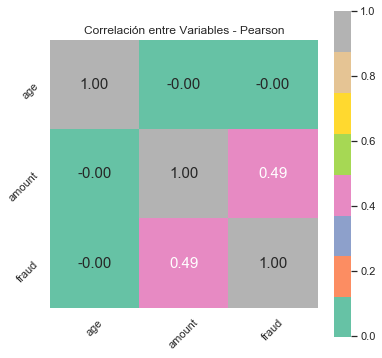

In [44]:
corr = banksim[['age','gender','category','amount','fraud']].corr()
plt.figure(figsize=(6,6))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15}, cmap= 'Set2')
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)
plt.title('Correlación entre Variables - Pearson')
plt.show()

In [47]:
df = pd.get_dummies(banksim, columns=['category'])
print (df)

        step       customer  age  gender zipcodeOri       merchant  \
0          0  'C1093826151'    4       2    '28007'   'M348934600'   
1          0   'C352968107'    2       2    '28007'   'M348934600'   
2          0  'C2054744914'    4       1    '28007'  'M1823072687'   
3          0  'C1760612790'    3       2    '28007'   'M348934600'   
4          0   'C757503768'    5       2    '28007'   'M348934600'   
...      ...            ...  ...     ...        ...            ...   
594638   179  'C1753498738'    3       1    '28007'  'M1823072687'   
594639   179   'C650108285'    4       1    '28007'  'M1823072687'   
594640   179   'C123623130'    2       1    '28007'   'M349281107'   
594641   179  'C1499363341'    5       2    '28007'  'M1823072687'   
594642   179   'C616528518'    4       1    '28007'  'M1823072687'   

       zipMerchant  amount  fraud  category_0  ...  category_5  category_6  \
0          '28007'    4.55      0           0  ...           0           0   
1  